In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("Training.xlsx")

df = df.iloc[2:].reset_index(drop=True)

df.columns = [
    "ID",
    "Default",
    "RevolvingUtilization",
    "Age",
    "Late30_59",
    "DebtRatio",
    "MonthlyIncome",
    "OpenCreditLines",
    "Late90",
    "RealEstateLoans",
    "Late60_89",
    "Dependents"
]

df = df.apply(pd.to_numeric, errors="coerce")

# Fill missing values
df.fillna(df.median(), inplace=True)


In [3]:
df["Late_Total"] = df["Late30_59"] + df["Late60_89"] + df["Late90"]
df["Debt_to_Income"] = df["DebtRatio"] / (df["MonthlyIncome"] + 1)
df["Credit_per_Dependent"] = df["OpenCreditLines"] / (df["Dependents"] + 1)

X = df.drop(columns=["ID", "Default"])
y = df["Default"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [4]:
# RANDOM FOREST

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)
rf_prob = rf.predict_proba(X_test)[:, 1]
rf_pred = (rf_prob >= 0.5).astype(int)

print("\n--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("AUC:", roc_auc_score(y_test, rf_prob))
print("Recall:", recall_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))




--- Random Forest ---
Accuracy: 0.8300056664777841
AUC: 0.8674332439368788
Recall: 0.7311720698254364
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.90     27996
         1.0       0.24      0.73      0.37      2005

    accuracy                           0.83     30001
   macro avg       0.61      0.78      0.63     30001
weighted avg       0.93      0.83      0.87     30001



In [5]:
# CREDIT DECISION LOGIC
# =====================
def credit_decision(prob):
    if prob < 0.3:
        return "Low Risk – Loan Approved"
    elif prob < 0.6:
        return "Medium Risk – Smaller Loan / Collateral"
    else:
        return "High Risk – Defer / Financial Coaching"


# SINGLE APPLICANT PREDICTION
# =========================
def predict_applicant(model, data_dict):
    input_df = pd.DataFrame([data_dict])
    prob = model.predict_proba(input_df)[0][1]
    amt = loan_amount_recommendation(prob)
    return {
        "Probability_of_Default": round(prob, 3),
        "Decision": credit_decision(prob),
        "Loan_Amount": amt
    }

def loan_amount_recommendation(prob, base_amount=50000):
    if prob < 0.3:
        return base_amount
    elif prob < 0.6:
        return base_amount * 0.5
    else:
        return 0

# Example test
sample_user = X_test.iloc[1].to_dict()
print("\nSample Prediction:")
print(predict_applicant(rf, sample_user))



Sample Prediction:
{'Probability_of_Default': np.float64(0.466), 'Decision': 'Medium Risk – Smaller Loan / Collateral', 'Loan_Amount': 25000.0}


In [6]:
import pandas as pd

feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feature_importance)


                 Feature  Importance
0   RevolvingUtilization    0.279838
10            Late_Total    0.250619
6                 Late90    0.116157
2              Late30_59    0.090139
8              Late60_89    0.056071
1                    Age    0.048673
3              DebtRatio    0.032477
11        Debt_to_Income    0.031447
4          MonthlyIncome    0.024676
12  Credit_per_Dependent    0.023664
5        OpenCreditLines    0.022417
7        RealEstateLoans    0.018119
9             Dependents    0.005701


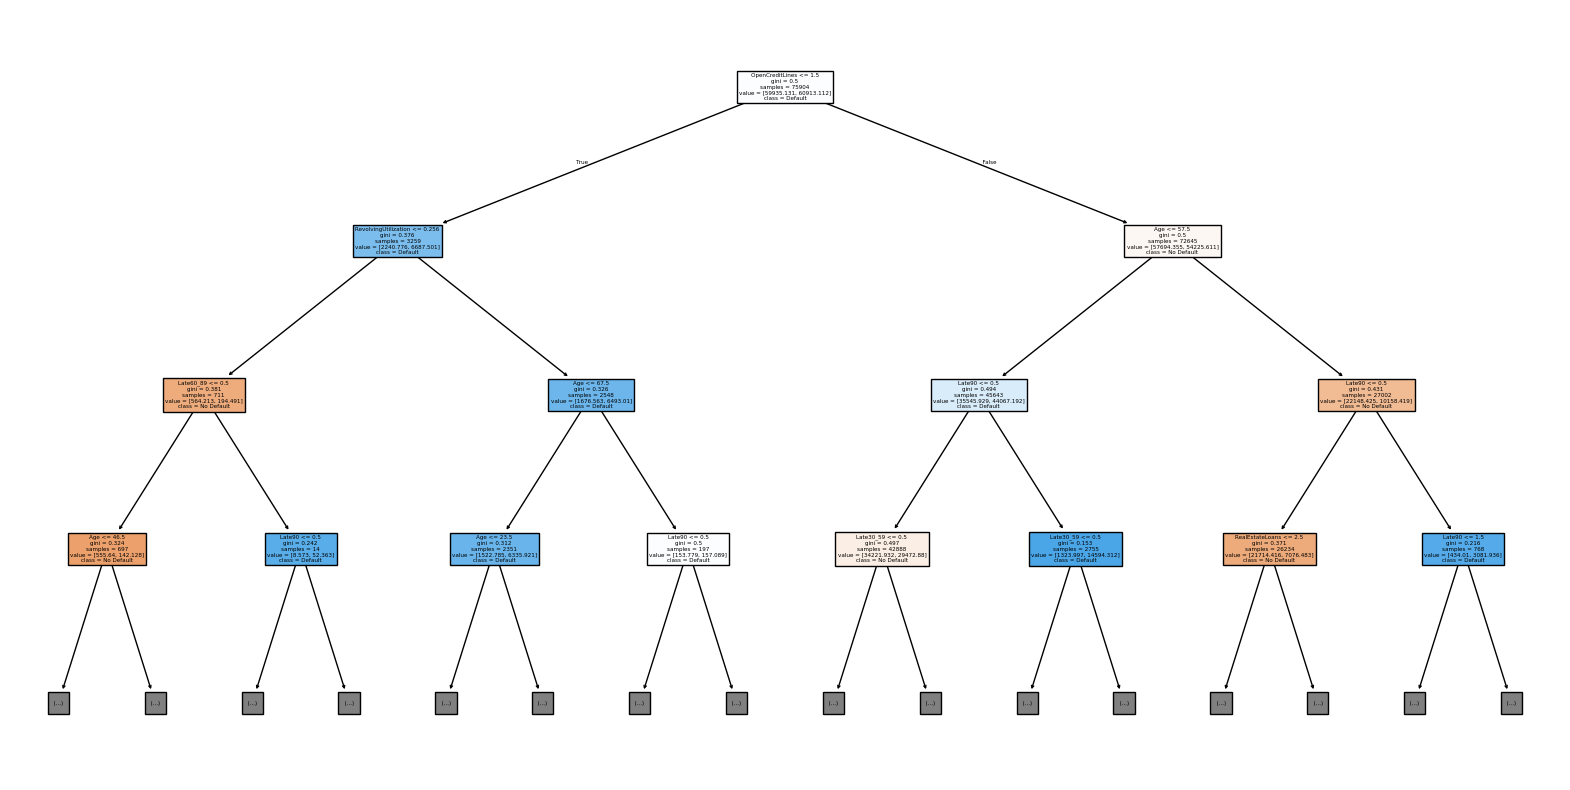

In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(
    rf.estimators_[0],
    feature_names=X_train.columns,
    class_names=["No Default", "Default"],
    filled=True,
    max_depth=3
)
plt.show()


In [9]:
# Compare risk distribution across age groups
df["Age_Group"] = pd.cut(df["Age"], bins=[18,25,40,60,100])
df.groupby("Age_Group")["Default"].mean()


,Default
Age_Group,
"(18, 25]",0.111662
"(25, 40]",0.102778
"(40, 60]",0.072188
"(60, 100]",0.029947


In [ ]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Global explanation
shap.summary_plot(shap_values[1], X_test)

# Single applicant explanation
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][0],
    X_test.iloc[0]
)


In [ ]:
def explain_prediction(model, explainer, X_row):
    shap_vals = explainer.shap_values(X_row)[1][0]
    explanation = sorted(
        zip(X_row.columns, shap_vals),
        key=lambda x: abs(x[1]),
        reverse=True
    )[:3]

    return [
        f"{feat} increased risk" if val > 0 else f"{feat} reduced risk"
        for feat, val in explanation
    ]

